#

In [15]:
import pandas as pd
import numpy as np

In [16]:
# interaction terms of loading and their feature names
import sklearn # check version
from sklearn.preprocessing import PolynomialFeatures
from itertools import combinations
import functools
import operator

In [17]:
# To plot pretty figures directly within Jupyter
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
from scipy.stats import ks_2samp
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# imputation
from sklearn.experimental import enable_iterative_imputer  # noqa
# Iterative Imputer: https://bit.ly/3euv1qW
# Iterative Imputation with missing values: https://bit.ly/2B1MgkM
from sklearn.impute import KNNImputer, IterativeImputer
# Byesian Ridge imputer : https://bit.ly/2BDYuQv
from sklearn.linear_model import BayesianRidge

In [18]:
import pickle

In [19]:
# IPython
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [20]:
PATH = r"G:\kaggleData\TReNDS"
fnc = pd.read_csv(f'{PATH}/fnc.csv').sort_values(by=['Id'])
loading = pd.read_csv(f'{PATH}/loading.csv').sort_values(by=['Id'])
train_scores = pd.read_csv(f'{PATH}/train_scores.csv').sort_values(by=['Id'])
reveal_id_site2 = pd.read_csv(f'{PATH}/reveal_ID_site2.csv')
id_site2 = reveal_id_site2.values.flatten().tolist()

In [21]:
# get attributes
fnc_features = fnc.columns.tolist()
fnc_features.remove('Id')
loading_features = loading.columns.tolist()
loading_features.remove('Id')
target_features = train_scores.columns.tolist()
target_features.remove('Id')

In [22]:
# dimension of data frames
dfs = [fnc, loading, train_scores, reveal_id_site2]
nms = ['fnc', 'loading', 'train_scores', 'reveal_id_site2']
for (df, nm) in zip(dfs, nms):
    df.name = nm
    print(f'{nm:16s}: shape {df.shape}')

fnc             : shape (11754, 1379)
loading         : shape (11754, 27)
train_scores    : shape (5877, 6)
reveal_id_site2 : shape (510, 1)


In [23]:
#
print(f'fnc_features:     len {len(fnc_features)}')
print(f'loading_features: len {len(loading_features)}')
print(f'target_features:  len {len(target_features)}')

fnc_features:     len 1378
loading_features: len 26
target_features:  len 5


In [24]:
# iteraction terms' names
def convertTuple(tup):
    str = functools.reduce(operator.add, tup)
    return str

In [25]:
polynomial_features = list(map(convertTuple, combinations(loading_features, r=2)))

In [26]:
# original loading features appended with interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
temp = poly.fit_transform(loading.drop(['Id'], axis=1).values)
loading2_features = loading_features + polynomial_features
loading2 = pd.concat([loading[['Id']], pd.DataFrame(temp, columns=loading2_features)], axis=1)

In [27]:
#
full_features = fnc_features + loading2_features
train_scores['is_train'] = True
full_data = pd.merge(fnc, loading2, on='Id').merge(train_scores, how='left', on='Id')
train_df = full_data.loc[full_data['is_train']==True, :].drop('is_train', axis=1)
test_df = full_data.loc[~(full_data['is_train']==True), :].drop(['is_train'], axis=1)

In [33]:
# target_scores
from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(color_pal)
mess = train_scores.copy()
mess['class'] = pd.cut(mess.age, bins=np.linspace(10, 90, 9).astype(int))

(10.0, 20.0]
(20.0, 30.0]
(30.0, 40.0]
(40.0, 50.0]
(50.0, 60.0]
(60.0, 70.0]
(70.0, 80.0]
(80.0, 90.0]


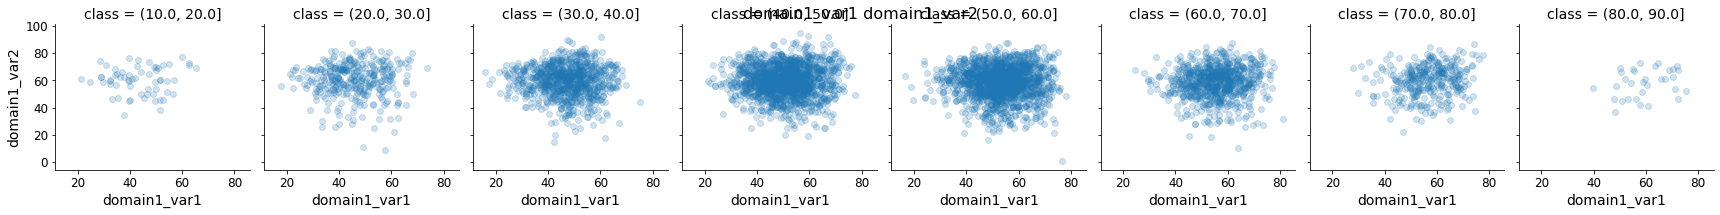

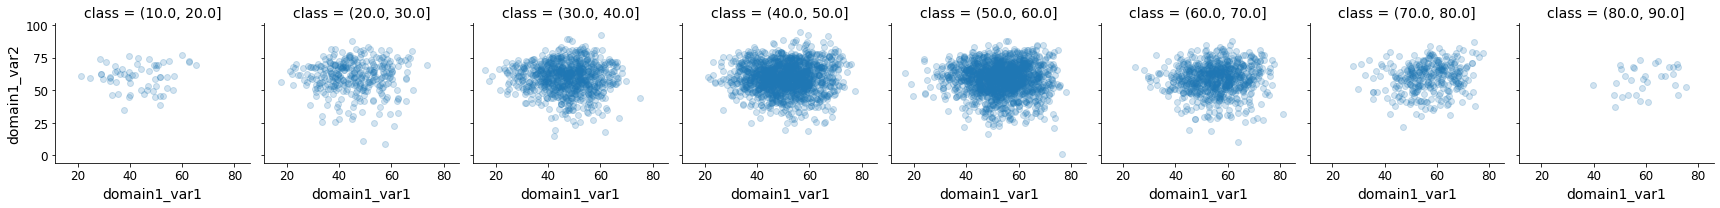

In [34]:
## skip it in production
def targetPlotByAgeGroup(df, col1, col2, alpha=0.2):
    # fig, ax = plt.subplots(constrained_layout=True)
    g = sns.FacetGrid(df, col='class', margin_titles=True)
    g = g.map(plt.scatter, col1, col2, alpha=alpha)
    g.fig.suptitle('testtest')
    plt.subplots_adjust(top=0.8)
    plt.show()

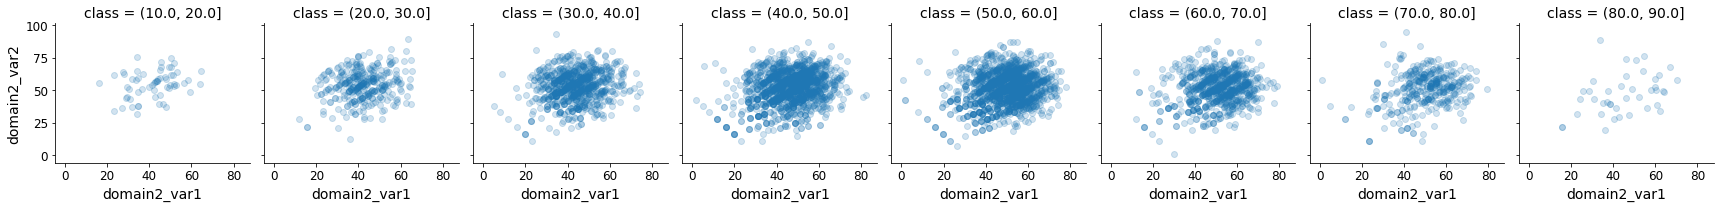

In [30]:
targetPlotByAgeGroup(mess, 'domain1_var1', 'domain1_var2')
targetPlotByAgeGroup(mess, 'domain2_var1', 'domain2_var2')
targetPlotByAgeGroup(mess, 'domain1_var1', 'domain2_var1')
targetPlotByAgeGroup(mess, 'domain1_var2', 'domain2_var2')

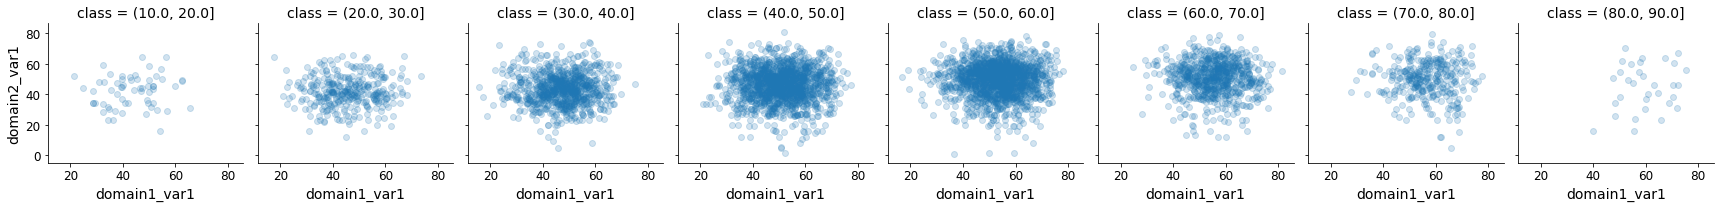

In [31]:
##
# reference: https://bit.ly/2B1MgkM {sklearn tech report}
# should we do any transformation before using the Iterator imputation? Answer: No need to transform.
def targetDistributionPlot(logTarget=[]):
    fig, axs = plt.subplots(ncols=5,nrows=1, figsize=(16,5))
    for i, col in enumerate(target_features):
        temp = mess[col]
        if col in logTarget:
            temp = np.log(temp)
        sns.kdeplot(temp, shade=True, ax=axs[i])
    plt.show()
targetDistributionPlot(logTarget=[])
targetDistributionPlot(logTarget=['domain2_var1', 'domain2_var2'])

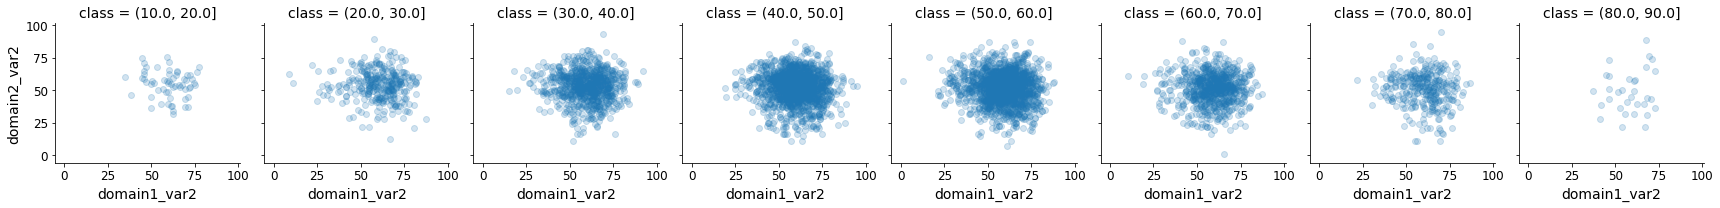

In [32]:
sns.boxplot(data=mess.drop(['class','Id','is_train'], axis=1), orient='h')
plt.show()
## remove outliers
temp = mess.set_index('Id').drop(['is_train', 'class'], axis=1)
q1 = temp.quantile(0.25) # lower quartile
q3 = temp.quantile(0.75) # upper quartile
iqr = q3 - q1
print(iqr)
print(f'count of outliers by features')
display(((temp < (q1 - 1.5 * iqr)) | (temp > (q3 + 1.5 * iqr))).sum())
print(f'entries with any outliers')
print((((temp < (q1 - 1.5 * iqr)) | (temp > (q3 + 1.5 * iqr))).sum(axis=1) > 0).sum())
pic2 = ((temp < (q1 - 1.5 * iqr)) | (temp > (q3 + 1.5 * iqr))).any(axis=1)
cntRemove1 = sum(pic2)
temp = temp.loc[~pic2].reset_index() # new data frame screening out outliers with ICQ * 1.5 rule

In [ ]:
##
# missing value in targets
def displayMissingValues(df, cols):
    size = df.shape[0]
    for col in cols:
        cnt = df[col].isnull().sum()
        print(f'{col:15s}: missing value {cnt:5d}, {cnt/size*100:.2f}%')
# displayMissingValues(train_df, target_features)
displayMissingValues(temp.drop('Id', axis=1), target_features)

In [ ]:
# To impute missing targets, we don't want our entries have more than 2 missing targets.
pic = temp.drop('Id', axis=1).isnull().sum(axis=1)>2
cntRemove2 = sum(pic)
print(f'the size of entries with more than 2 missing targets: {cntRemove2}') # 34
# check to see how many of them are actually from site 2. (Answer: None)
box = temp.loc[pic, 'Id'].values.tolist()
# sanity check: to see if box is different from id_site2. Ans: None
print([i for i in box if i in id_site2])
# Create new data frame after removing entries with more than 2 missing targets
df_imputed = temp.loc[~temp['Id'].isin(box),:]
print(f'Removed {cntRemove1 + cntRemove2} entries.')
print(f'New shape of training data: {df_imputed.shape}')

In [ ]:
##
# imputation
imputer = IterativeImputer(missing_values=np.nan,
                           estimator=BayesianRidge(),
                           random_state=0,
                           max_iter=30,
                           sample_posterior=True)
##
ss_id = df_imputed['Id'].copy() # training set Id in original order
df_imputed = imputer.fit_transform(df_imputed.set_index('Id'))
df_imputed = pd.DataFrame(df_imputed, columns=target_features, index=ss_id)

In [ ]:
##
train_df = pd.merge(train_df, df_imputed, left_on='Id', right_index=True, suffixes=('_old',''))
train_df = train_df.set_index('Id')
test_df = test_df.set_index('Id')
with open('trends_imputed_version.pkl', 'wb') as f:
    pickle.dump([train_df, test_df, ss_id, fnc_features, loading_features, target_features, polynomial_features], f)

In [ ]:
#todo: scaling is important. reshuffle is important. stacking.